# DSC540 Project 4

In [1]:
!pip install pgmpy

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

from scipy import stats
from scipy.stats import binom, gamma, beta, poisson
from sklearn import metrics
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Q1 [10]

A drug company would like to introduce a drug to help patients with Alzheimer's. It is desirable to estimate $θ$, the proportion of the market share that this drug will capture.
- The company interviews 100 people and 15 of them say that they will buy the drug. (This the observed data: n=100, observed=15) $->$ likelihood
- If in the past new drugs tend to capture a proportion between say .10 and .40 of the market, and if all values in between are assumed equally likely, then $θ ∼ Unif(0.10, 0.40)$ $->$ prior

**What is the traceplot of $\theta$ using Bayesian analysis to estimate the market share for the new drug?**
- Sample 10000 draws
- Plot the traceplot
- Plot the posterior distribution plot of $ \theta $
- What is the mean posterior value?

In [2]:
with pm.Model() as model:
    theta = pm.Uniform("theta", lower = 0.10, upper = 0.40)
    x = pm.Binomial(name = "observations", n = 100, p = theta, observed = 15)
    trace = pm.sample(draws = 10000, tune = 1000, chains = 4)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


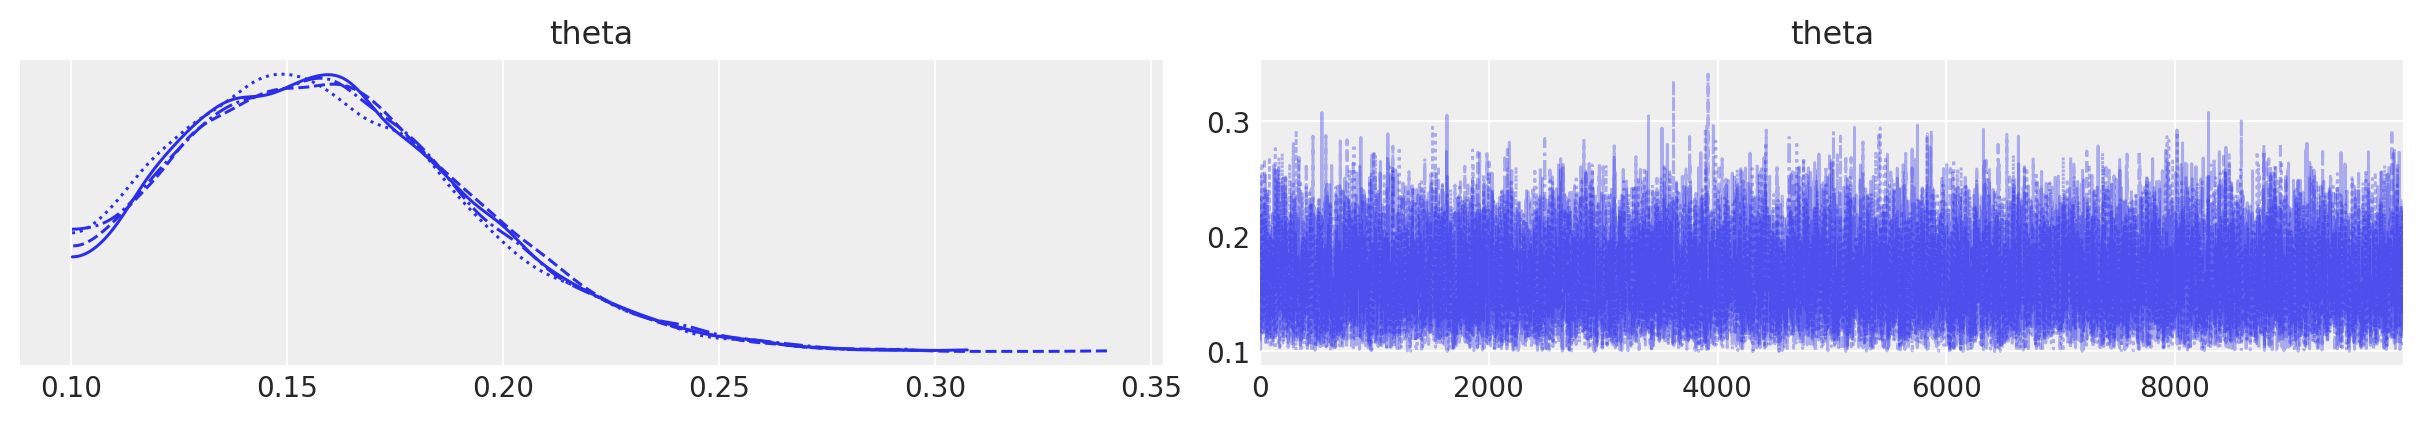

In [3]:
with model:
      az.plot_trace(trace)

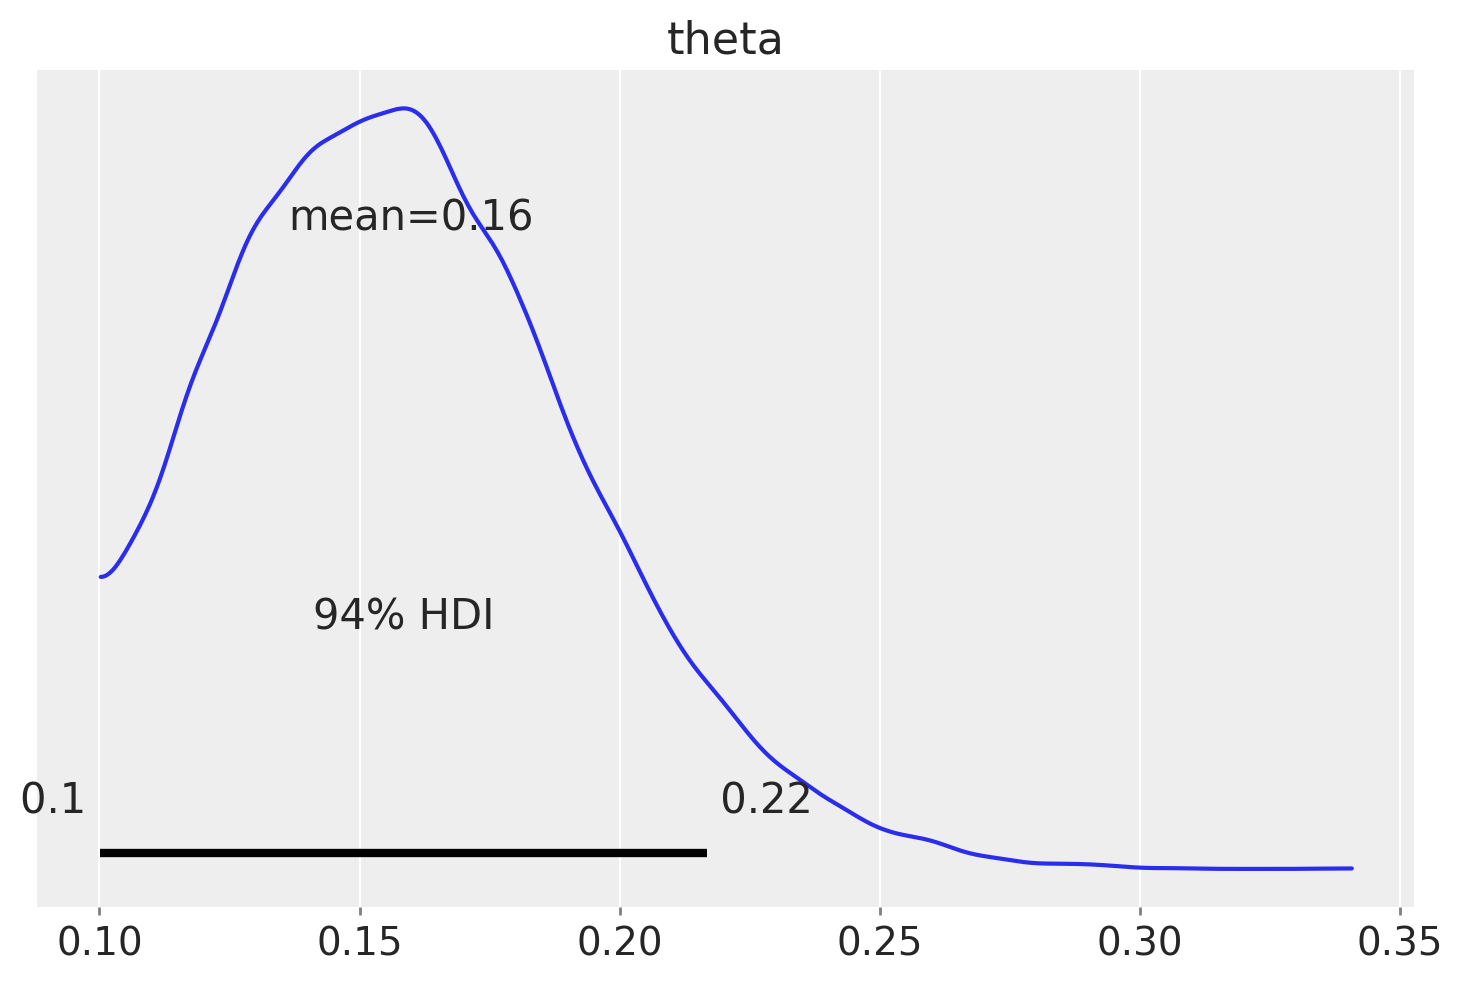

In [4]:
with model:
  az.plot_posterior(trace)

A. The mean posterior value is 0.16

## Q2 [10]

**Define the model structure.**

In [5]:
model = BayesianModel([('Smokes', 'LungDisease'), ('LungDisease', 'ShortnessOfBreath'), ('LungDisease', 'ChestPain'), ('LungDisease', 'Cough'), ('Cold', 'Cough'), ('Cold', 'Fever')])

## Q3 [15]

**Define individual CPDs**
- Define the CPDs using the state names of the variables.

In [6]:
cpd_smokes = TabularCPD(variable = 'Smokes',
                        variable_card = 2,
                        values = [[0.2], [0.8]],
                        state_names = {'Smokes': ['T', 'F']})
print(cpd_smokes)

cpd_lungdisease = TabularCPD(variable = 'LungDisease',
                             variable_card = 2,
                             values = [[0.1009, 0.001],
                                       [0.8991, 0.999]],
                             evidence = ['Smokes'],
                             evidence_card = [2],
                             state_names = {'Smokes': ['T', 'F'], 'LungDisease': ['T', 'F']})
print(cpd_lungdisease)

+-----------+-----+
| Smokes(T) | 0.2 |
+-----------+-----+
| Smokes(F) | 0.8 |
+-----------+-----+
+----------------+-----------+-----------+
| Smokes         | Smokes(T) | Smokes(F) |
+----------------+-----------+-----------+
| LungDisease(T) | 0.1009    | 0.001     |
+----------------+-----------+-----------+
| LungDisease(F) | 0.8991    | 0.999     |
+----------------+-----------+-----------+


In [7]:
cpd_cold = TabularCPD(variable = 'Cold',
                      variable_card = 2,
                      values = [[0.02], [0.98]],
                      state_names = {'Cold': ['T', 'F']})

cpd_fever = TabularCPD(variable = 'Fever',
                       variable_card = 2,
                       values = [[0.307, 0.01],
                                 [0.693, 0.99]],
                       evidence = ['Cold'],
                       evidence_card = [2],
                       state_names = {'Cold': ['T', 'F'], 'Fever': ['T', 'F']})

cpd_chestpain = TabularCPD(variable = 'ChestPain',
                             variable_card = 2,
                             values = [[0.208, 0.01],
                                       [0.792, 0.99]],
                             evidence = ['LungDisease'],
                             evidence_card = [2],
                             state_names = {'LungDisease': ['T', 'F'], 'ChestPain': ['T', 'F']})

cpd_shortnessofbreath = TabularCPD(variable = 'ShortnessOfBreath',
                                     variable_card = 2,
                                     values = [[0.208, 0.01],
                                               [0.792, 0.99]],
                                     evidence = ['LungDisease'],
                                     evidence_card = [2],
                                     state_names = {'LungDisease': ['T', 'F'], 'ShortnessOfBreath': ['T', 'F']})

cpd_cough = TabularCPD(variable = 'Cough',
                       variable_card = 2,
                       values=[[0.7525, 0.505, 0.505, 0.01],
                               [0.2475, 0.495, 0.495, 0.99]],
                       evidence = ['LungDisease', 'Cold'],
                       evidence_card = [2, 2],
                       state_names = {'LungDisease': ['T', 'F'], 'Cold': ['T', 'F'], 'Cough': ['T', 'F']})

## Q4 [5]
**Check that each of the CPDs are correct**

In [8]:
cpd_smokes

<TabularCPD representing P(Smokes:2) at 0x7b88e6fbe8f0>

In [9]:
print(cpd_smokes)

+-----------+-----+
| Smokes(T) | 0.2 |
+-----------+-----+
| Smokes(F) | 0.8 |
+-----------+-----+


In [10]:
print(cpd_smokes)
print(cpd_lungdisease)
print(cpd_cold)
print(cpd_fever)
print(cpd_chestpain)
print(cpd_shortnessofbreath)
print(cpd_cough)

+-----------+-----+
| Smokes(T) | 0.2 |
+-----------+-----+
| Smokes(F) | 0.8 |
+-----------+-----+
+----------------+-----------+-----------+
| Smokes         | Smokes(T) | Smokes(F) |
+----------------+-----------+-----------+
| LungDisease(T) | 0.1009    | 0.001     |
+----------------+-----------+-----------+
| LungDisease(F) | 0.8991    | 0.999     |
+----------------+-----------+-----------+
+---------+------+
| Cold(T) | 0.02 |
+---------+------+
| Cold(F) | 0.98 |
+---------+------+
+----------+---------+---------+
| Cold     | Cold(T) | Cold(F) |
+----------+---------+---------+
| Fever(T) | 0.307   | 0.01    |
+----------+---------+---------+
| Fever(F) | 0.693   | 0.99    |
+----------+---------+---------+
+--------------+----------------+----------------+
| LungDisease  | LungDisease(T) | LungDisease(F) |
+--------------+----------------+----------------+
| ChestPain(T) | 0.208          | 0.01           |
+--------------+----------------+----------------+
| ChestPain(F) | 0

## Q5 [5]
**Add the defined CPDs to the model (Associate the CPDs with the network)**

In [11]:
model.add_cpds(cpd_cold, cpd_fever, cpd_lungdisease, cpd_chestpain, cpd_shortnessofbreath, cpd_cough, cpd_smokes)
model.check_model()

True

## Q6 [5]
**The cardinality of each of the nodes is 2 - True or False?**

In [12]:
model.get_cardinality()

defaultdict(int,
            {'Cold': 2,
             'Fever': 2,
             'LungDisease': 2,
             'ChestPain': 2,
             'ShortnessOfBreath': 2,
             'Cough': 2,
             'Smokes': 2})

The statement 'The cardinality of each of the nodes is 2' is true.

### Q7 [10]
**Find the probability of each event hapenning using the variable elimination method.**
- $ P(Smokes) $
- $ P(Cold) $
- $ P(LungDisease) $
- $ P(ShortnessBreath) $
- $ P(ChestPain) $
- $ P(Fever) $
- $ P(Cough) $
- $ P(LungDisease|Smokes=True) $
- $ P(LungDisease|Cough=True) $
- $ P(ShortnessBreath|Smokes=True) $
- $ P(ChestPain|Fever=True) $

In [13]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [14]:
print("P(Smokes):\n", infer.query(['Smokes']))
print("P(Cold):\n", infer.query(['Cold']))
print("P(LungDisease):\n", infer.query(['LungDisease']))
print("P(ShortnessOfBreath):\n", infer.query(['ShortnessOfBreath']))
print("P(ChestPain):\n", infer.query(['ChestPain']))
print("P(Fever):\n", infer.query(['Fever']))
print("P(Cough):\n", infer.query(['Cough']))
print("P(LungDisease | Smokes = True):\n", infer.query(['LungDisease'], evidence = {'Smokes': 'T'}))
print("P(LungDisease | Cough = True):\n", infer.query(['LungDisease'], evidence = {'Cough': 'T'}))
print("P(ShortnessOfBreath | Smokes = True):\n", infer.query(['ShortnessOfBreath'], evidence = {'Smokes': 'T'}))
print("P(ChestPain | Fever = True):\n", infer.query(['ChestPain'], evidence = {'Fever': 'T'}))

P(Smokes):
 +-----------+---------------+
| Smokes    |   phi(Smokes) |
+===========+===============+
| Smokes(T) |        0.2000 |
+-----------+---------------+
| Smokes(F) |        0.8000 |
+-----------+---------------+
P(Cold):
 +---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.0200 |
+---------+-------------+
| Cold(F) |      0.9800 |
+---------+-------------+
P(LungDisease):
 +----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+
P(ShortnessOfBreath):
 +----------------------+--------------------------+
| ShortnessOfBreath    |   phi(ShortnessOfBreath) |
+======================+==========================+
| ShortnessOfBreath(T) |                   0.0142 |
+----------------------+--------------------------+
| Shor

## Q8 [15]
**Are the following  true? If not, can you make them independent by including info on the parent?**
1. Cough is independent from Fever. (Having knowledge about Fever does not change the probability of Cough)
2. Fever is independent from Smokes.
3. ChestPain is independent from Smokes.
4. ChestPain is independent from Smokes given LungDisease.


##### 1. Cough is independent from Fever

In [15]:
dist = infer.query(['Cough'])
print(dist)

dist = infer.query(['Cough'], evidence = {'Fever': 'T'})
print(dist)

dist = infer.query(['Cough'], evidence = {'Fever': 'F'})
print(dist)

dist = infer.query(['Cough'], evidence = {'Cold': 'F', 'Fever': 'T'})
print(dist)

dist = infer.query(['Cough'], evidence = {'Cold': 'F', 'Fever': 'F'})
print(dist)

dist = infer.query(['Cough'], evidence = {'Cold': 'T', 'Fever': 'T'})
print(dist)

dist = infer.query(['Cough'], evidence = {'Cold': 'T', 'Fever': 'F'})
print(dist)

+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0302 |
+----------+--------------+
| Cough(F) |       0.9698 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.2091 |
+----------+--------------+
| Cough(F) |       0.7909 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0273 |
+----------+--------------+
| Cough(F) |       0.9727 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0204 |
+----------+--------------+
| Cough(F) |       0.9796 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0204 |
+----------+--------------+
| Cough(F) |       0.9796 |
+----------+--------------+
+----------+--------

- Fever does affect Cough -> Not independent
- However, given the parent of both Fever and Cough (Cold), they should be independent.

##### 2. Fever is independent from Smokes.

In [16]:
dist = infer.query(['Fever'])
print(dist)

dist = infer.query(['Fever'], evidence = {'Smokes': 'T'})
print(dist)

dist = infer.query(['Fever'], evidence = {'Smokes': 'F'})
print(dist)

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+


- Smokes does not affect Fever -> Independent

##### 3. ChestPain is independent from Smokes.

In [17]:
dist = infer.query(['ChestPain'])
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'F'})
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'F', 'LungDisease': 'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'F', 'LungDisease': 'F'})
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'T', 'LungDisease': 'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence = {'Smokes': 'T', 'LungDisease': 'F'})
print(dist)

+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0142 |
+--------------+------------------+
| ChestPain(F) |           0.9858 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0300 |
+--------------+------------------+
| ChestPain(F) |           0.9700 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0102 |
+--------------+------------------+
| ChestPain(F) |           0.9898 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.2080 |
+--------------+------------------+
| ChestPain(F) |           0.7920 |
+--------------+------------

- Smokes does affect Chast Pain -> Not independent
- However, when Lung Disease is given, they are independent.

## Q9 [20]
1. Does having the knowledge that the person is coughing increase the probability of lung disease?
2. Does having the knowledge that the person is coughing increase the probability that the person has Cold?
3. Does having the knowledge that the person is coughing increase the probability that there is Fever?
4. Does having the knowledge that the person is coughing increase the probability that there is Fever, given the person has Cold?
5. Does having the knowledge that the person has Fever increase the probability that there is Lung Disease?


##### 1. Does having the knowledge that the person is coughing increase the probability of lung disease? [5]

In [18]:
dist = infer.query(['LungDisease'])
print(dist)

dist = infer.query(['LungDisease'], evidence = {'Cough': 'T'})
print(dist)

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+
+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.3545 |
+----------------+--------------------+
| LungDisease(F) |             0.6455 |
+----------------+--------------------+


Having the knowledge that the person is coughing increases the probability of lung disease.

##### 2. Does having the knowledge that the person is coughing increase the probability that the person has Cold? [5]

In [19]:
dist = infer.query(['Cold'])
print(dist)

dist = infer.query(['Cold'], evidence = {'Cough': 'T'})
print(dist)

+---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.0200 |
+---------+-------------+
| Cold(F) |      0.9800 |
+---------+-------------+
+---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.3381 |
+---------+-------------+
| Cold(F) |      0.6619 |
+---------+-------------+


Having the knowledge that the person is coughing increases the probability of cold.

##### 3. Does having the knowledge that the person is coughing increase the probability that there is Fever? [5]

In [20]:
dist = infer.query(['Fever'])
print(dist)

dist = infer.query(['Fever'], evidence = {'Cough': 'T'})
print(dist)

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.1104 |
+----------+--------------+
| Fever(F) |       0.8896 |
+----------+--------------+


Having the knowledge that the person is coughing increases the probability of fever.

##### 4. Does having the knowledge that the person is coughing increase the probability that there is Fever, given the person has Cold?

In [21]:
dist = infer.query(['Fever'])
print(dist)

dist = infer.query(['Fever'], evidence = {'Cough': 'T', 'Cold': 'T'})
print(dist)

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.3070 |
+----------+--------------+
| Fever(F) |       0.6930 |
+----------+--------------+


Having the knowledge that the person is coughing increases the probability of fever given the person has Cold.

##### 5. Does having the knowledge that the person has Fever increase the probability that there is Lung Disease?

In [22]:
dist = infer.query(['LungDisease'])
print(dist)

dist = infer.query(['LungDisease'], evidence = {'Fever': 'T'})
print(dist)

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+


+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+


Having the knowledge that the person has fever does not increase the probability of lung disease.

## Q10 [5]
1. What's the most probable state of Cough?
2. What's the most probable state of Cough given Cold is True?
3. What's the most probable state of Cough given Cold is True and Lung Disease is True?

##### 1. What's the most probable state of Cough?

In [23]:
infer.map_query(['Cough'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'Cough': 'F'}

The most probable state of Cough is False.

##### 2. What's the most probable state of Cough given Cold is True?

In [24]:
infer.map_query(['Cough'], evidence = {'Cold': 'T'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'Cough': 'T'}

The most probable state of Cough given Cold is true is True.

##### 3. What's the most probable state of Cough given Cold is True and Lung Disease is True?

In [25]:
infer.map_query(['Cough'], evidence = {'Cold': 'T', 'LungDisease': 'T'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Cough': 'T'}

The most probable state of Cough given Cold is true and given Lung Disease is true is True.